<a href="https://colab.research.google.com/github/DVORA-AZARKOVICH/Narrative-Similarity/blob/main/NarrativeSimilarityGemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Narrative Similarity: Gemini Distillation & Embeddings
**SemEval-2026 Task 4: Narrative Similarity (Track A)**

This notebook implements a "Distill-then-Embed" approach for detecting narrative similarity.
**The Strategy:**
1.  **Distill:** Use **Gemini 1.5 Flash** to strip away surface details (names, specific settings, writing style) and extract the "Narrative Core" (Abstract Theme, Course of Action, Outcomes).
2.  **Embed:** Use Google's **Text-Embedding-004** model to convert the *distilled* core summaries into vector representations.
3.  **Compare:** Calculate Cosine Similarity between the *Anchor* story and the two candidates (*Text A* and *Text B*) to determine which is closer in terms of narrative structure.

## 1. Load Data
Loading the Synthetic training data and the Development set (Track A) from Google Drive.

In [ ]:
!pip install -q -U google-generativeai

import google.genai as genai
import pandas as pd
from tqdm import tqdm
import time
import os
from google.colab import drive

drive.mount('/content/drive')

from google.colab import userdata
try:
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
except:
    print("Please set your GOOGLE_API_KEY in the Colab secrets or manually here.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

BASE_PATH = '/content/drive/MyDrive/Narrative Similarity Data/'

SYNTHETIC_FILE = BASE_PATH + 'synthetic_data_for_classification.jsonl'
df_synthetic = pd.read_json(SYNTHETIC_FILE, lines=True)
print("--- Synthetic Data Loaded ---")
print(f"Shape: {df_synthetic.shape}")

DEV_FILE = BASE_PATH + 'SemEval2026-Task_4-dev-v1/dev_track_a.jsonl'
df_dev = pd.read_json(DEV_FILE, lines=True)
print("\n--- Development Data Loaded ---")
print(f"Shape: {df_dev.shape}")

--- Synthetic Data Loaded ---
Shape: (1900, 5)

--- Development Data Loaded ---
Shape: (200, 4)


In [ ]:
df_synthetic = df_synthetic.drop(columns=['model_name'])

df_train = df_synthetic.copy()

## 2. Narrative Distillation (Gemini 1.5 Flash)
This is the preprocessing step. Raw stories often contain "distractors" (like genre specific keywords or character names) that confuse embedding models.

We define a **System Prompt** that instructs the LLM to rewrite the story summary, keeping **only**:
* **Abstract Theme:** The central problem/idea.
* **Course of Action:** The sequence of events/conflicts.
* **Outcomes:** The resolution.

We apply this to the `anchor_text`, `text_a`, and `text_b` columns.

In [ ]:
import google.generativeai as genai
from tqdm import tqdm
import pandas as pd

from google.colab import userdata
try:
    if not genai.configure(api_key=GOOGLE_API_KEY):
        pass
except:
    pass

distillation_system_prompt = """
You are an expert annotator tasked with extracting the 'Narrative Core' of a story.

### DEFINITIONS
Extract the core based ONLY on:
1. **Abstract Theme**: The defining constellation of problems and central ideas.
2. **Course of Action**: The sequence of events, actions, conflicts, and turning points.
3. **Outcomes**: The results of the plot (resolution, fates).

### WHAT TO IGNORE
Explicitly REMOVE and IGNORE:
* The concrete setting (e.g., Sci-Fi, Western, dates, locations).
* Names of characters.
* The style of writing.

### OUTPUT INSTRUCTION
Rewrite the story summary to include ONLY the Abstract Theme, Course of Action, and Outcomes. Do not analyze, just describe the narrative core neutrally.
"""

model_distill = genai.GenerativeModel('gemini-1.5-flash',
                                      system_instruction=distillation_system_prompt)

def distill_narrative(text):
    try:
        if not isinstance(text, str): return ""
        response = model_distill.generate_content(text)
        return response.text.strip()
    except Exception as e:
        return text

tqdm.pandas(desc="Distilling Stories")
cols_to_distill = ['anchor_text', 'text_a', 'text_b']

print("Starting distillation...")
for col in cols_to_distill:
    print(f"Distilling column: {col}...")
    try:
        df_dev[f'{col}_core'] = df_dev[col].progress_apply(distill_narrative)
    except:
        df_dev[f'{col}_core'] = df_dev[col].apply(distill_narrative)


Starting distillation...
Distilling column: anchor_text...


Distilling Stories: 100%|██████████| 200/200 [00:42<00:00,  4.65it/s]


Distilling column: text_a...


Distilling Stories: 100%|██████████| 200/200 [00:43<00:00,  4.62it/s]


Distilling column: text_b...


Distilling Stories: 100%|██████████| 200/200 [00:41<00:00,  4.79it/s]


## 3. Generate Embeddings & Calculate Similarity
Now that we have the "Narrative Cores" (stripped of surface noise), we generate vector embeddings for them.

**Method:**
1.  Generate embeddings using `models/text-embedding-004`.
2.  Calculate **Cosine Similarity** between:
    * Anchor -> Text A
    * Anchor -> Text B
3.  **Prediction:** If `Score(Anchor, A) > Score(Anchor, B)`, we predict **1** (A is closer). Otherwise, **0** (B is closer).

In [ ]:
import numpy as np
from numpy.linalg import norm
import google.generativeai as genai
from tqdm import tqdm
import getpass
import pandas as pd
from google.colab import userdata

try:
    if not genai.configure(api_key=GOOGLE_API_KEY):
        pass
except:
    pass

EMBEDDING_MODEL = 'models/text-embedding-004'

print(f"\nAttempting to connect to embedding model: {EMBEDDING_MODEL}...")

try:
    test_emb = genai.embed_content(
        model=EMBEDDING_MODEL,
        content="test",
        task_type="semantic_similarity"
    )
    print("✅ SUCCESS! Embedding model found and working.")

except Exception as e:
    print(f"\n❌ Error connecting to {EMBEDDING_MODEL}: {e}")
    print("\n--- Debugging: Available Models for your Key ---")
    try:
        for m in genai.list_models():
            if 'embed' in m.name:
                print(f"- {m.name}")
                if not 'text-embedding-004' in m.name:
                     pass
    except Exception as list_err:
        print(f"Could not list models: {list_err}")

    print("\nIf you see other embedding models above (like 'models/embedding-001'), replace EMBEDDING_MODEL in the code with one of them.")
    raise e


def get_embedding(text):
    if not isinstance(text, str) or not text.strip():
        return np.zeros(768)

    try:
        result = genai.embed_content(
            model=EMBEDDING_MODEL,
            content=text,
            task_type="semantic_similarity"
        )
        return np.array(result['embedding'])
    except Exception as e:
        return np.zeros(768)

def cosine_similarity(vec_a, vec_b):
    if np.all(vec_a == 0) or np.all(vec_b == 0):
        return 0.0
    return np.dot(vec_a, vec_b) / (norm(vec_a) * norm(vec_b))

tqdm.pandas(desc="Embeddings")

print("\n--- Starting Full Embedding Process ---")


cols = ['anchor_text', 'text_a', 'text_b']
suffix = '_core' if 'anchor_text_core' in df_dev.columns else ''

print(f"Using columns with suffix: '{suffix}'")

df_dev['anchor_emb'] = df_dev[f'anchor_text{suffix}'].progress_apply(get_embedding)
df_dev['text_a_emb'] = df_dev[f'text_a{suffix}'].progress_apply(get_embedding)
df_dev['text_b_emb'] = df_dev[f'text_b{suffix}'].progress_apply(get_embedding)

print("Calculating Scores...")
df_dev['score_a'] = df_dev.apply(lambda row: cosine_similarity(row['anchor_emb'], row['text_a_emb']), axis=1)
df_dev['score_b'] = df_dev.apply(lambda row: cosine_similarity(row['anchor_emb'], row['text_b_emb']), axis=1)

df_dev['predicted_label'] = (df_dev['score_a'] > df_dev['score_b']).astype(int)

print("\n--- Done! Results Sample ---")
print(df_dev[['score_a', 'score_b', 'predicted_label']].head())

Please paste your Google API Key below and press Enter:
··········

Attempting to connect to embedding model: models/text-embedding-004...
✅ SUCCESS! Embedding model found and working.

--- Starting Full Embedding Process ---
Using columns with suffix: '_core'


Embeddings: 100%|██████████| 200/200 [01:25<00:00,  2.35it/s]

Calculating Scores...

--- Done! Results Sample ---
    score_a   score_b  predicted_label
0  0.499465  0.587253                0
1  0.584422  0.562942                1
2  0.556780  0.621297                0
3  0.587901  0.595861                0
4  0.644016  0.649350                0


### Save Embeddings
Saving the processed DataFrame (including the high-dimensional vectors) to a Pickle file. This allows us to reload the data later without re-running the API calls.

In [ ]:
import os

OUTPUT_FILE = BASE_PATH + 'dev_with_embeddings_gemini.pkl'

try:
    df_dev.to_pickle(OUTPUT_FILE)
    print(f"✅ Successfully saved DataFrame with embeddings to:\n{OUTPUT_FILE}")
except Exception as e:
    print(f"❌ Error saving file: {e}")


✅ Successfully saved DataFrame with embeddings to:
/content/drive/MyDrive/Narrative Similarity Data/dev_with_embeddings_gemini.pkl


## 4. Evaluation
Comparing our predictions against the ground truth (`text_a_is_closer`).
We visualize the performance using a **Confusion Matrix** and a **Classification Report** (Precision, Recall, F1-Score).

--- Classification Report ---

                 precision    recall  f1-score   support

B is closer (0)       0.62      0.62      0.62        99
A is closer (1)       0.62      0.62      0.62       101

       accuracy                           0.62       200
      macro avg       0.62      0.62      0.62       200
   weighted avg       0.62      0.62      0.62       200



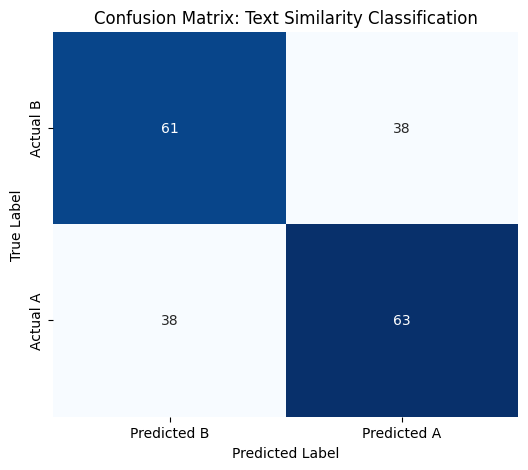

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

TRUE_LABEL_COL = 'text_a_is_closer'

if TRUE_LABEL_COL not in df_dev.columns:
    print(f"⚠️ Warning: Column '{TRUE_LABEL_COL}' not found in DataFrame.")
    print(f"Available columns: {df_dev.columns.tolist()}")
    print("Cannot calculate Confusion Matrix without ground truth labels.")
else:
    y_true = df_dev[TRUE_LABEL_COL]
    y_pred = df_dev['predicted_label']

    print("--- Classification Report ---\n")
    print(classification_report(y_true, y_pred, target_names=['B is closer (0)', 'A is closer (1)']))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted B', 'Predicted A'],
                yticklabels=['Actual B', 'Actual A'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: Text Similarity Classification')
    plt.show()

## 5. Prepare Submission
Formatting the predictions into the required JSONL format for SemEval and compressing it into a ZIP file for download.

In [ ]:
import zipfile
from google.colab import files

submission_df = df_dev[['predicted_label']].copy()

submission_df = submission_df.rename(columns={'predicted_label': 'text_a_is_closer'})

jsonl_filename = 'track_a.jsonl'
submission_df.to_json(jsonl_filename, orient='records', lines=True)
print(f"Saved intermediate JSONL: {jsonl_filename}")

zip_filename = 'submission_zeroshot.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(jsonl_filename)

print(f"Successfully created: {zip_filename}")

files.download(zip_filename)